# Census Tract + Boundary Cleanup

Here I will gather all the Census data from San Francisco, and merge it with Boundary and Tract Data.


### Loading Dependencies


In [10]:
!pip install -r ../requirements.txt -q

In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from us import states
import contextily as ctx
from census import Census
from matplotlib import ticker

from dotenv import load_dotenv
import os

load_dotenv()
censusAPIKey = os.getenv(
    "CENSUS_API_KEY"
)  # Make sure to add your API key to a .env file

## Loading County Boundary of San Francisco

Courtesty of [SF Open Data](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Bay-Area-Counties/s9wg-vcph)


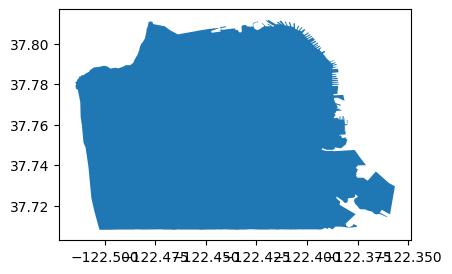

In [12]:
# Bay Area Counties data from data.sfgov.org
bay_area_counties = gpd.read_file(
    "../data/gis/Bay_Area_County_Polygons_20251212.geojson"
)

sf_county_boundary = bay_area_counties[bay_area_counties.county == "San Francisco"]

# Filter to only include mainland SF
parts = sf_county_boundary.to_crs(26910).explode(index_parts=False)

# keep only “big enough” polygons (tune threshold)
parts = parts[parts.area > 5e7]  # 50 km^2 as a starting point

sf_mainland = parts.dissolve().to_crs(4326)

ax = sf_mainland.plot(figsize=(6, 3))
ax.set_aspect("equal")

## Loading in Census Tract Data from 2023


In [ ]:
sfCountyTracts = Census(censusAPIKey).acs5.state_county_tract(
    fields=(
        "NAME",
        "B01003_001E",  # total population
        "B19013_001E",  # median household income
        "B17001_001E",  # poverty universe
        "B17001_002E",  # below poverty
        "B19083_001E",  # Gini index
        "B25077_001E",  # median home value
        "B25064_001E",  # median rent
        "B25003_002E",  # owner-occupied units
        "B25003_003E",  # renter-occupied units
        "B15003_022E",  # bachelor's degree
        "B15003_023E",  # master's degree
        "B15003_025E",  # doctorate degree
        "B15003_001E",  # total population 25+ (education base)
        "B08301_010E",  # commute: drove alone
        "B08301_018E",  # commute: public transit
        "B08301_021E",  # commute: work from home
        "B03002_003E",  # white alone, not Hispanic
        "B03002_004E",  # Black or African American alone
        "B03002_006E",  # Asian alone
        "B03002_012E",  # Hispanic / Latino (any race)
    ),
    state_fips="06",
    county_fips="075",
    tract="*",
    year=2023,
)

# Convert to DataFrame
sf_tracts_df = pd.DataFrame(sfCountyTracts)

# Rename for clarity
sf_tracts_df = sf_tracts_df.rename(
    columns={
        "B01003_001E": "total_population",
        "B19013_001E": "median_household_income",
        "B17001_001E": "poverty_universe",
        "B17001_002E": "below_poverty",
        "B19083_001E": "gini_index",
        "B25077_001E": "median_home_value",
        "B25064_001E": "median_rent",
        "B25003_002E": "owner_occupied_units",
        "B25003_003E": "renter_occupied_units",
        "B15003_022E": "bachelors_degree",
        "B15003_023E": "masters_degree",
        "B15003_025E": "doctorate_degree",
        "B15003_001E": "education_universe",
        "B08301_010E": "commute_drove_alone",
        "B08301_018E": "commute_public_transit",
        "B08301_021E": "commute_work_from_home",
        "B03002_003E": "white_alone_not_hispanic",
        "B03002_004E": "black_or_african_american_alone",
        "B03002_006E": "asian_alone",
        "B03002_012E": "hispanic_latino",
    }
)

### Filtering out bad data


In [ ]:
sentinels = [-666666666, -777777777, -888888888, -999999999]
sf_tracts_df.replace(sentinels, np.nan, inplace=True)
maybe_zero_is_missing = [
    "median_household_income",
    "median_home_value",
    "median_rent",
    "gini_index",
    "total_population",
]
sf_tracts_df[maybe_zero_is_missing] = sf_tracts_df[maybe_zero_is_missing].replace(
    0, np.nan
)

sf_tracts_df.describe()

,total_population,median_household_income,poverty_universe,below_poverty,gini_index,median_home_value,median_rent,owner_occupied_units,renter_occupied_units,bachelors_degree,masters_degree,doctorate_degree,education_universe,commute_drove_alone,commute_public_transit,commute_work_from_home,white_alone_not_hispanic,black_or_african_american_alone,asian_alone,hispanic_latino
count,241.000000,237.000000,244.000000,244.000000,240.000000,2.200000e+02,239.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.00000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,3470.211618,144302.459916,3374.418033,357.110656,0.478975,1.435185e+06,2488.740586,572.172131,914.098361,961.901639,457.799180,93.651639,2742.778689,416.77459,63.963115,534.127049,1285.077869,164.930328,1189.000000,546.172131
std,1320.544676,57967.563281,1355.319821,264.776900,0.062871,3.682835e+05,770.316910,424.766839,500.707884,469.731337,316.089462,88.321229,1067.063557,223.02142,76.552859,338.250370,767.650548,269.226478,902.638246,444.721352
min,49.000000,13569.000000,0.000000,0.000000,0.211600,4.686000e+05,323.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2518.000000,104648.000000,2415.250000,175.500000,0.440350,1.144075e+06,2088.000000,258.750000,557.500000,643.500000,245.500000,32.750000,2045.250000,260.00000,12.000000,297.500000,684.000000,27.750000,482.250000,233.750000
50%,3470.000000,146477.000000,3355.500000,287.500000,0.473950,1.414550e+06,2583.000000,500.500000,847.500000,946.000000,400.000000,69.500000,2777.500000,390.00000,37.500000,516.500000,1220.500000,75.500000,913.000000,420.500000
75%,4197.000000,182375.000000,4135.750000,478.000000,0.518375,1.708325e+06,3102.000000,798.500000,1240.750000,1273.250000,632.250000,140.750000,3391.000000,547.25000,95.750000,682.250000,1806.750000,180.000000,1642.500000,711.750000
max,8415.000000,250001.000000,7911.000000,1838.000000,0.744700,2.000001e+06,3501.000000,2266.000000,2470.000000,2538.000000,2044.000000,796.000000,6637.000000,1189.00000,508.000000,2199.000000,3650.000000,2513.000000,4414.000000,2580.000000


### Extrapolating useful data


In [ ]:
# Poverty rate
sf_tracts_df["poverty_rate"] = (
    sf_tracts_df["below_poverty"] / sf_tracts_df["poverty_universe"]
)

# % with bachelor's or higher (bachelor's + master's + doctorate)
sf_tracts_df["bachelors_plus_rate"] = (
    sf_tracts_df["bachelors_degree"]
    + sf_tracts_df["masters_degree"]
    + sf_tracts_df["doctorate_degree"]
) / sf_tracts_df["education_universe"]

# % renter-occupied
sf_tracts_df["pct_renter_occupied"] = sf_tracts_df["renter_occupied_units"] / (
    sf_tracts_df["owner_occupied_units"] + sf_tracts_df["renter_occupied_units"]
)

# Race shares
race_total = (
    sf_tracts_df["white_alone_not_hispanic"]  # white
    + sf_tracts_df["black_or_african_american_alone"]  # Black
    + sf_tracts_df["asian_alone"]  # Asian
    + sf_tracts_df["hispanic_latino"]  # Hispanic/Latino
)
sf_tracts_df["share_white"] = sf_tracts_df["white_alone_not_hispanic"] / race_total
sf_tracts_df["share_black"] = (
    sf_tracts_df["black_or_african_american_alone"] / race_total
)
sf_tracts_df["share_asian"] = sf_tracts_df["asian_alone"] / race_total
sf_tracts_df["share_hispanic"] = sf_tracts_df["hispanic_latino"] / race_total

# Build a tract GEOID we can merge on later
sf_tracts_df["GEOID"] = (
    sf_tracts_df["state"] + sf_tracts_df["county"] + sf_tracts_df["tract"]
)

## Merging with Census Tract Geometries


In [ ]:
# Load raw SF tracts from Census TIGER/Line shapefiles 2023
caTracts = gpd.read_file(
    f"https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_06_tract.zip"
)

# Join census data with geeometrics
sfCensusGDF = caTracts.merge(sf_tracts_df, on="GEOID", how="right")

left = sfCensusGDF.to_crs(26910).copy()
mask = sf_mainland.to_crs(26910).copy()

# if mask has multiple parts, dissolve into one geometry
mask_geom = mask.dissolve().geometry.iloc[0]

# intersection area fraction
inter_area = left.geometry.intersection(mask_geom).area
frac = inter_area / left.geometry.area

# keep if at least 10% of the polygon is inside the mask (tune 0.10)
left_keep = left[frac > 0.10].copy()

# (optional) replace geometry with the clipped shape so nothing sticks out into water
left_keep["geometry"] = left_keep.geometry.intersection(mask_geom)
sfCensusGDF = left_keep

**Basic Plot**

Below is a dashboard of maps to verify that everything works smoothly.


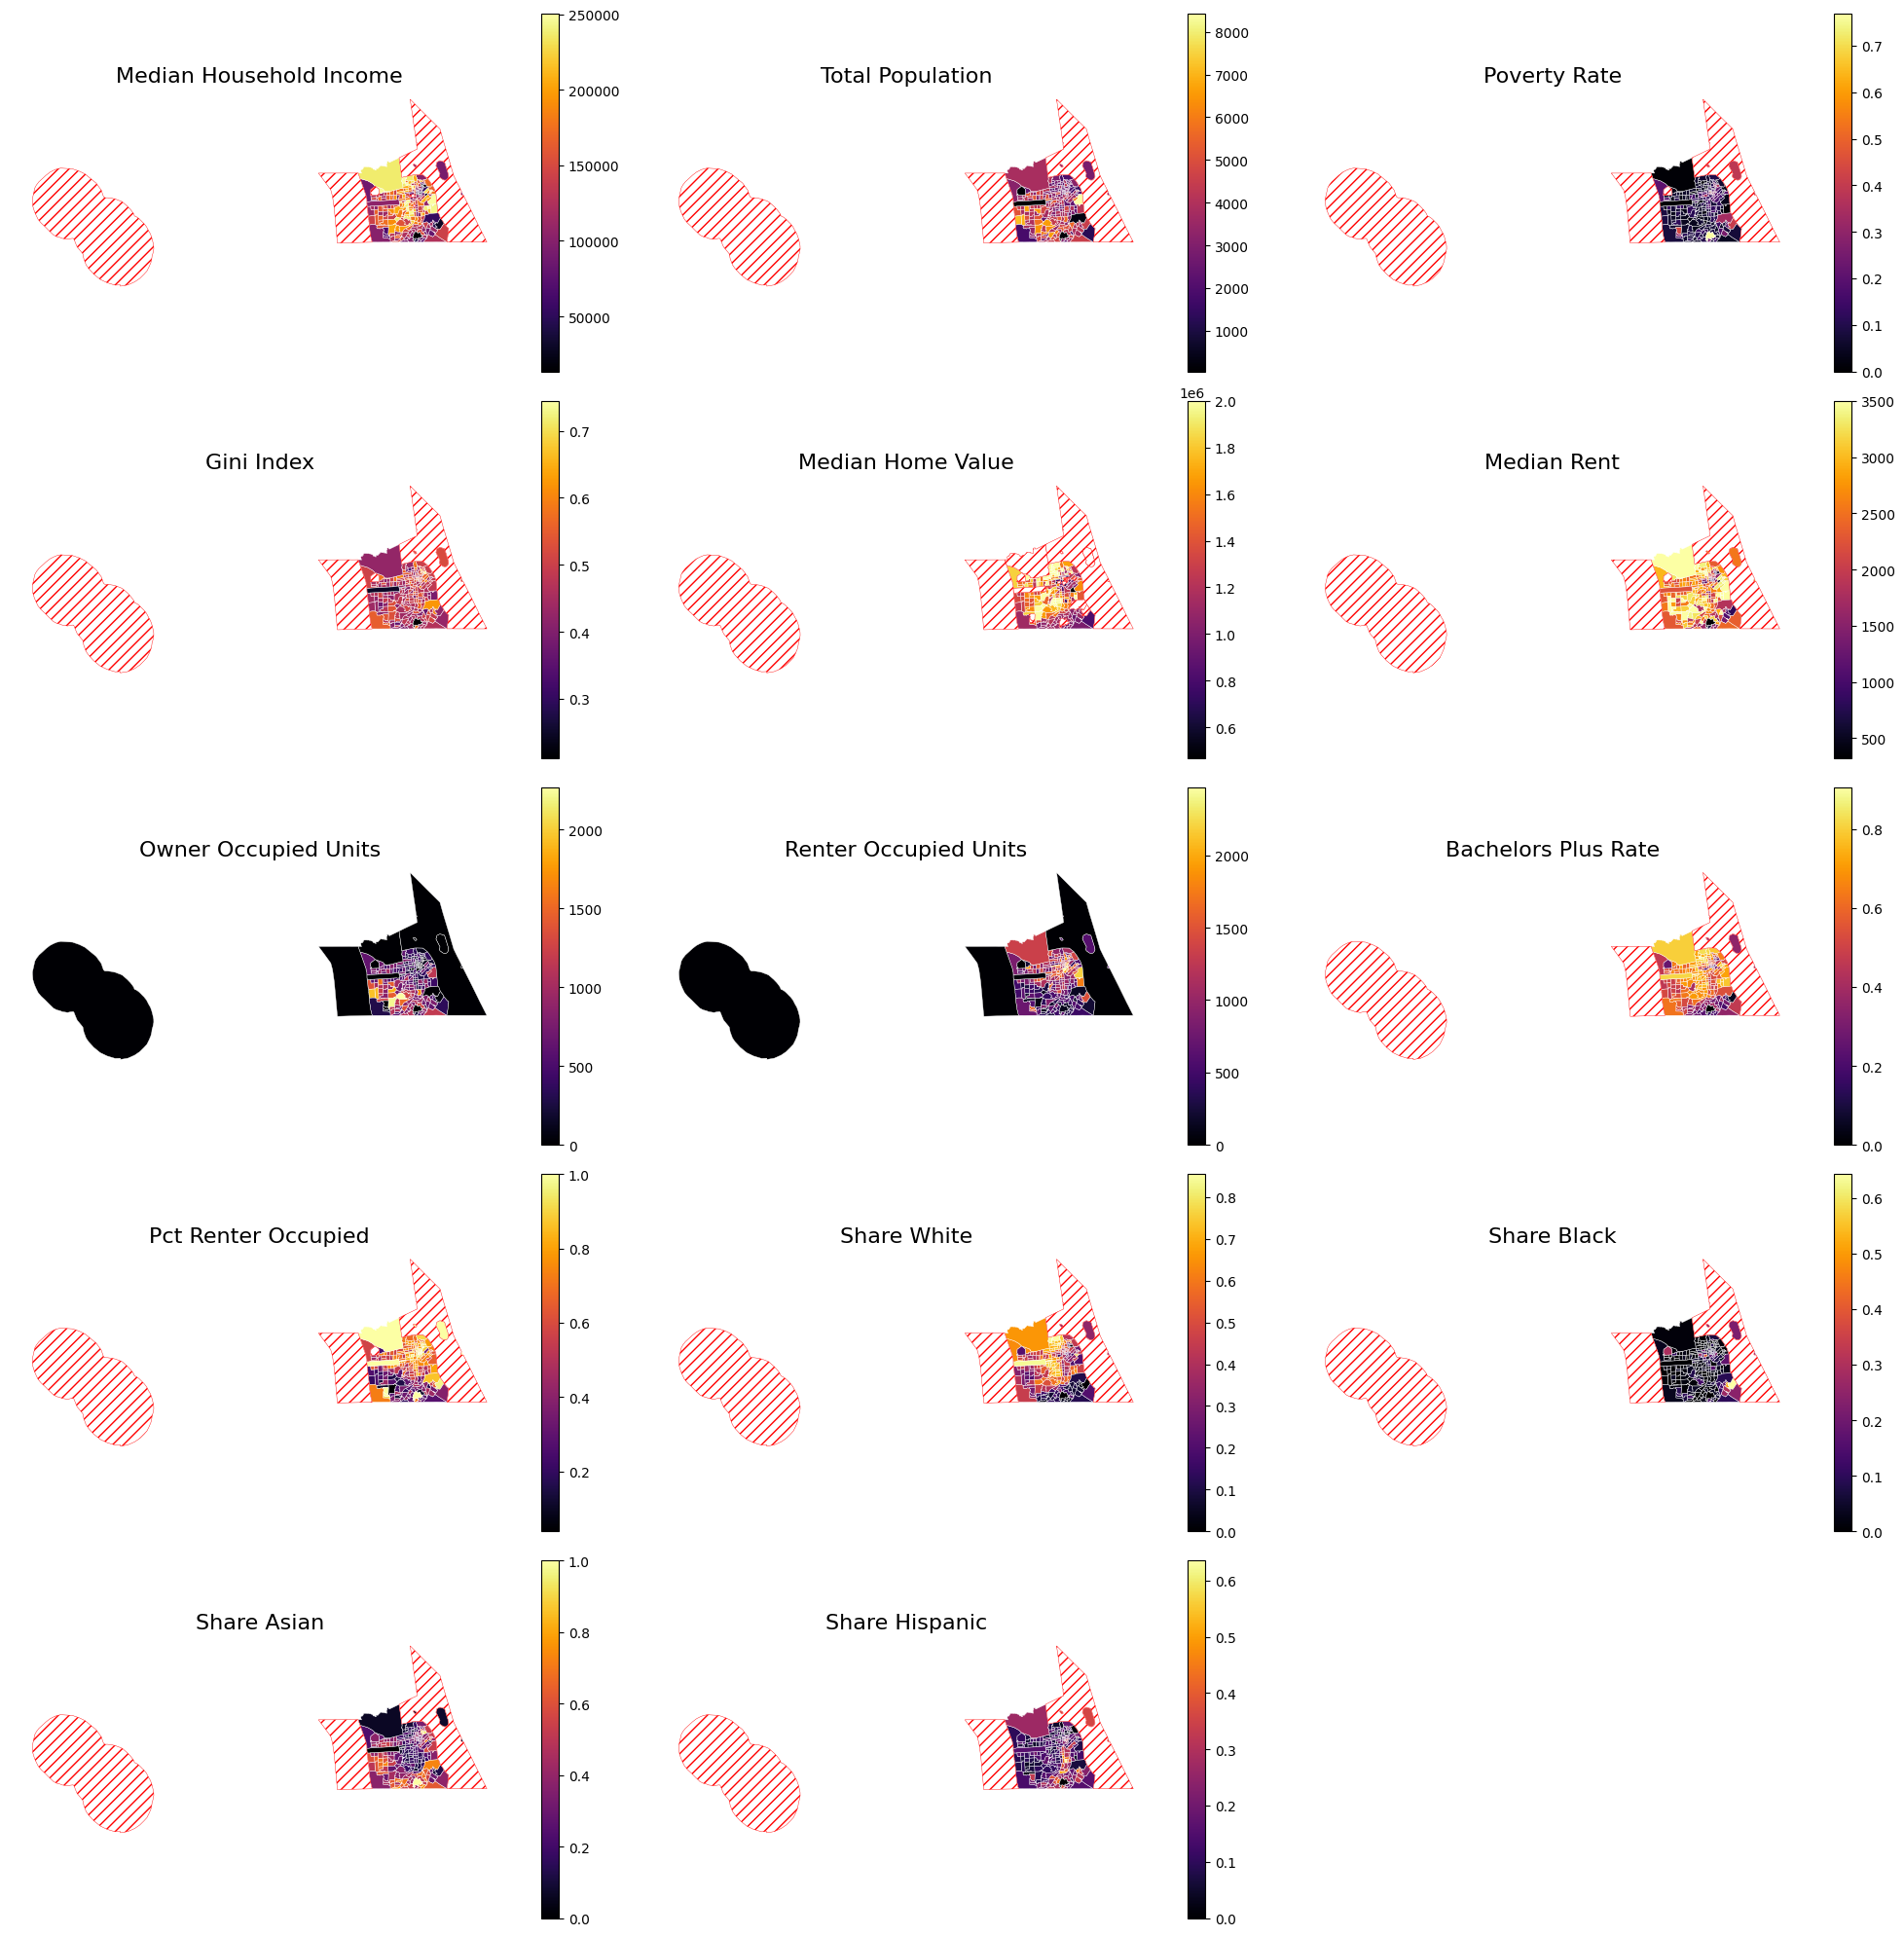

In [ ]:
# Columns from acs + the ones we derived
acs_columns = [
    "median_household_income",
    "total_population",
    "poverty_rate",
    "gini_index",
    "median_home_value",
    "median_rent",
    "owner_occupied_units",
    "renter_occupied_units",
    "bachelors_plus_rate",
    "pct_renter_occupied",
    "share_white",
    "share_black",
    "share_asian",
    "share_hispanic",
]

# Printing multiple maps in a grid
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(acs_columns):
    ax = axes[i]

    sfCensusGDF.plot(
        ax=ax,
        column=col,
        legend=True,
        edgecolor="white",
        linewidth=0.3,
        cmap="inferno",
        missing_kwds={
            "facecolor": "white",
            "edgecolor": "red",
            "hatch": "///",
            "label": "No data",
        },
    )
    ax.set_title(col.replace("_", " ").title(), fontsize=16)
    ax.set_axis_off()

# Hide extra subplots if fewer than 16
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Boom!

And now we're done! The ACS 2023 data in San Francisco is perfectly fitted towards to boundary!


In [ ]:
sfCensusGDF.to_file("../data/processed/sf_tracts_cleaned_2023.gpkg", driver="GPKG")